In [1]:
!pip install pybullet
!pip install tqdm

     |████████████████████████████████| 76.6MB 54kB/s 


Mounted at /content/gdrive


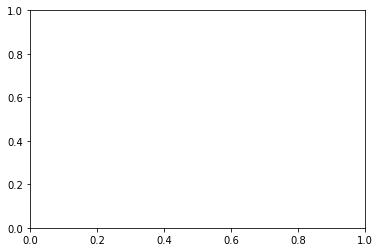

In [2]:
import torch
import gym
import pybullet_envs
from gym import envs
from torch.optim import Adam
import random
from copy import deepcopy
from collections import deque
import torch.nn as nn
import numpy as np
from torch.distributions import Distribution, Independent, Normal, TransformedDistribution
from torch.distributions.transforms import AffineTransform, TanhTransform
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
DTYPE = torch.float64
torch.set_default_dtype(DTYPE)


from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/My Drive/SAC_IMG/'


fig, ax = plt.subplots()
def plot(step, reward, title, epoch=1000000, steps=[], rewards=[]):
    steps.append(step)
    rewards.append(reward)
    ax.plot(steps, rewards, 'b-')
    ax.set_title(title)
    ax.set_xlabel('Steps')
    ax.set_ylabel('Rewards')
    ax.set_xlim((0, epoch))
    ax.set_ylim((-100, 1000))
    fig.savefig(f"{images_dir}"+title + '.png')

LOG_MIN = -20
LOG_MAX = 2


def fcnn_policy(layer_sizes, activation_function=nn.Tanh, output_activation=nn.Identity):
    """
    This is a basic fully connected neural network, used as an default for the basic model
    @param layer_sizes: a list of integers that specify each hidden layers size
    @param activation_function: Specify the activation function for the hidden layers.
    @param output_activation: The activation function for the output layer.
    @return: nn.Sequential
    """
    nn_layers = []
    for j in range(len(layer_sizes)-1):
        activation = activation_function if j < len(layer_sizes)-2 else output_activation
        nn_layers += [nn.Linear(layer_sizes[j], layer_sizes[j+1]), activation()]
    return nn.Sequential(*nn_layers)  #Star "unpacks" the list, in to args for the function


class TanhNormal(Distribution):
    """Copied from Kaixhi"""
    def __init__(self, loc, scale):
        super().__init__()
        self.normal = Independent(Normal(loc, scale), 1)

    def sample(self):
        return torch.tanh(self.normal.sample())

    # samples with re-parametrization trick (differentiable)
    def rsample(self):
        return torch.tanh(self.normal.rsample())

    # Calculates log probability of value using the change-of-variables technique
    # (uses log1p = log(1 + x) for extra numerical stability)
    def log_prob(self, value):
        inv_value = (torch.log1p(value) - torch.log1p(-value)) / 2  # artanh(y)
        # log p(f^-1(y)) + log |det(J(f^-1(y)))|
        return self.normal.log_prob(inv_value) - torch.log1p(-value.pow(2) + 1e-6).sum(dim=1)

    @property
    def mean(self):
        return torch.tanh(self.normal.mean)

    def get_std(self):
        return self.normal.stddev


class SoftActor(nn.Module):
    def __init__(self, observation_dim, action_dim, hidden_layer_size=(256, 256),
                 activation_function=nn.Tanh, output_activation=nn.Identity,
                 action_scale=1.0, action_loc=0.0):
        super().__init__()
        """The network have output size of action_dim*2 because output of this network are 
        divided in to the mu and log_std component of a gaussian distribution"""
        self.network = fcnn_policy([observation_dim]+list(hidden_layer_size)+[2*action_dim],
                                   activation_function=activation_function, output_activation=output_activation)
        self.scale = action_scale
        self.loc = action_loc

    def forward(self, state, mean_action=False):
        mu, log_std = self.network(state).chunk(2, dim=-1)
        log_std = torch.clamp(log_std, LOG_MIN, LOG_MAX)  # to make it not too random/deterministic
        normal = TransformedDistribution(Independent(Normal(mu, log_std.exp()), 1),
                                         [TanhTransform(), AffineTransform(loc=self.loc, scale=self.scale)])
        if mean_action:
            return self.loc*torch.tanh(mu) + self.scale
        return normal


class Critic(nn.Module):
    def __init__(self, observation_dim, action_dim=None, hidden_layer_size=(256, 256),
                 activation_function=nn.Tanh, output_activation=nn.Identity):
        super().__init__()
        network_architecture = [observation_dim + (action_dim if action_dim is not None else 0)] + list(hidden_layer_size) + [1]
        self.network = fcnn_policy(network_architecture,
                                   activation_function=activation_function, output_activation= output_activation)

    def forward(self, state, action=None):
        if action is None:
            value = self.network(state)
        else:
            value = self.network(torch.cat([state, action], dim=-1))
        return value.squeeze(dim=-1)


class SoftActorCritic(nn.Module):

    def __init__(self, observation_dim, action_dim, hidden_layer_size=(256, 256),
                 activation_function=nn.ReLU, output_activation=nn.Identity, action_scale=1.0, action_loc=0.0):
        super().__init__()
        self.actor = SoftActor(observation_dim=observation_dim, action_dim=action_dim,
                               hidden_layer_size=hidden_layer_size, activation_function=activation_function,
                               output_activation=output_activation, action_scale=action_scale, action_loc=action_loc)
        self.critic_v = Critic(observation_dim=observation_dim, action_dim=None,
                               hidden_layer_size=hidden_layer_size, activation_function=activation_function,
                               output_activation=output_activation)

        self.critic_q1 = Critic(observation_dim=observation_dim, action_dim=action_dim,
                                hidden_layer_size=hidden_layer_size, activation_function=activation_function,
                                output_activation=output_activation)

        self.critic_q2 = Critic(observation_dim=observation_dim, action_dim=action_dim,
                                hidden_layer_size=hidden_layer_size, activation_function=activation_function,
                                output_activation=output_activation)
        self.target_critic_v = deepcopy(self.critic_v)
        for param in self.target_critic_v.parameters():
            param.requires_grad = False
        self.name = "Soft Actor Critic"

    def copy_target_critic_v(self):
        self.target_critic_v = deepcopy(self.critic_v)
        for param in self.target_critic_v.parameters():
            param.requires_grad = False

    def forward(self, state, mean_action=False):
        return self.actor(state, mean_action=mean_action)



In [3]:

def save_model_checkpoint(model: torch.nn.Module, optimizer: torch.optim.Optimizer, criterion=0, epochs=0, replay_buffer=[], steps=[], rewards=[], filename='./saved_model.pth'):
    torch.save({
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': criterion,
        'replay_buffer': replay_buffer,
        'steps': steps,
        'rewards': rewards
                },  filename)


def load_model_checkpoint(model: torch.nn.Module, optimizer: torch.optim.Optimizer, filename='./saved_model.pth'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return model, optimizer, checkpoint['loss'], checkpoint['epoch'], checkpoint['replay_buffer'], checkpoint['steps'], checkpoint['rewards']


In [4]:
DTYPE = torch.float64
torch.set_default_dtype(DTYPE)

def sac(policy=SoftActorCritic, epoch=1000000, gamma=0.99, polyak=0.995,
        actor_lr=3e-4, critic_lr=3e-4, alpha=0.2, buffer_size=1000000,
        off_policy_batch_size=1000, reward_scale=1, initial_exploration=10000,
        update_interval=1, test_interval=1000, load_agent=False, save_agent=False):

    envname = "HumanoidBulletEnv-v0" #'MountainCarContinuous-v0' #'Pendulum-v0
    env = gym.make(envname)


    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.shape[0]
    # Scaling of action
    max_action = env.action_space.high[0]
    min_action = env.action_space.low[0]
    clamping = 1e-10
    scaling_factor = (env.action_space.high[0] - env.action_space.low[0])/2
    scaling_const = (env.action_space.high[0] + env.action_space.low[0])/2

    def scale_action(act):
        scaled_act= scaling_factor*act + scaling_const
        return act
        #return np.clip(scaling_factor*act + scaling_const,
        #                env.action_space.low[0], env.action_space.high[0])

    def test(actor, render=False):
        with torch.no_grad():
            actor.eval()
            state, total_reward, done = env.reset(), 0, False

            while not done:
                action = actor(torch.as_tensor(state, dtype=DTYPE), mean_action=True)
                #env.render() if render is True else _
                state, reward, done, _ = env.step(scale_action(action.numpy()))
                total_reward += reward
            #env.close() #crashes mujoco_py
            #plot_mountain_cart(agent) if render else _
            actor.train()
        return total_reward

    agent = policy(observation_space, action_space, hidden_layer_size=(256, 256), activation_function=nn.ReLU,
                   action_scale=scaling_factor, action_loc=scaling_const)
    actor_optimizer = Adam(agent.actor.parameters(), lr=actor_lr)
    critic_q_optimizer = Adam(list(agent.critic_q1.parameters())+list(agent.critic_q2.parameters()), lr=critic_lr)
    critic_v_optimizer = Adam(agent.critic_v.parameters(), lr=critic_lr)
    replay_buffer = deque(maxlen=buffer_size)

    # Loading parameters from previous run
    prev_loss = 0
    prev_epoch = 0
    steps, rewards = [], []
    if load_agent:
        agent.actor, actor_optimizer, prev_loss, prev_epoch, replay_buffer, steps, rewards = load_model_checkpoint(agent.actor, actor_optimizer, filename=f"{images_dir}"+"/save_points/SAC_actor.pth") #temporary workaround
        agent.critic_v, critic_v_optimizer, _, _, _, _, _ = load_model_checkpoint(agent.critic_v, critic_v_optimizer, filename=f"{images_dir}"+"/save_points/SAC_critic_v.pth")
        agent.critic_q1, critic_q_optimizer, _, _, _, _, _ = load_model_checkpoint(agent.critic_q1, critic_q_optimizer, filename=f"{images_dir}"+"/save_points/SAC_critic_q1.pth")
        agent.critic_q2, critic_q_optimizer, _, _, _, _, _ = load_model_checkpoint(agent.critic_q2, critic_q_optimizer, filename=f"{images_dir}"+"/save_points/SAC_critic_q2.pth")
        agent.copy_target_critic_v()  # make sure target_critic is also updated

    def update(episodes, update_target=False):
        states = torch.as_tensor([ep[0] for ep in episodes], dtype=DTYPE)
        actions = torch.stack([ep[1] for ep in episodes])
        rewards = torch.as_tensor([ep[2] for ep in episodes], dtype=DTYPE)
        next_states = torch.as_tensor([ep[3] for ep in episodes], dtype=DTYPE)
        is_done = torch.as_tensor([ep[-1] for ep in episodes], dtype=DTYPE)
        # Target for V
        pi = agent.actor(states)
        sample_actions = torch.clamp(pi.rsample(), min_action + clamping, max_action - clamping)
        entropy_component = alpha * pi.log_prob(sample_actions)
        critic_q = torch.min(agent.critic_q2(states, sample_actions),
                             agent.critic_q1(states, sample_actions)).detach()
        target_v = critic_q - entropy_component.detach()

        # Update V
        critic_v_loss = (agent.critic_v(states) - target_v).pow(2).mean()
        critic_v_optimizer.zero_grad()
        critic_v_loss.backward()
        critic_v_optimizer.step()
        # Target for Q
        target_q = rewards + gamma * (1-is_done) * agent.target_critic_v(next_states)
        # Update Q
        critic_q_loss = (agent.critic_q1(states, actions) - target_q).pow(2).mean() + \
                        (agent.critic_q2(states, actions) - target_q).pow(2).mean()
        critic_q_optimizer.zero_grad()
        critic_q_loss.backward()
        critic_q_optimizer.step()


        # Update Policy
        target_pi = torch.min(agent.critic_q2(states, sample_actions), agent.critic_q1(states, sample_actions))
        loss_pi = (entropy_component - target_pi).mean()
        actor_optimizer.zero_grad()
        loss_pi.backward()
        actor_optimizer.step()
        if torch.isnan(loss_pi).any().item() or torch.isnan(critic_q_loss).any().item() or torch.isnan(critic_v_loss).any().item():
            print("what the hell")
        if torch.isinf(loss_pi).any().item() or torch.isinf(critic_q_loss).any().item() or torch.isinf(critic_v_loss).any().item():
            print("what the hell")

        # Update target V
        for V_param, target_V_param in zip(agent.critic_v.network.parameters(), agent.target_critic_v.network.parameters()):
            target_V_param.data = polyak * target_V_param.data + (1 - polyak) * V_param.data

    total_reward = 0
    i = 0

    try:
        state, done = env.reset(), False
        progress_bar = tqdm(range(1+prev_epoch, epoch+1), unit_scale=1, smoothing=0)
        for i in progress_bar:
            with torch.no_grad():
                if i < initial_exploration:
                    # uniform distribution action taken for better exploration at the beginning roughtly 10%
                    action = torch.tensor(np.random.rand(action_space)*2 - 1)
                else:
                    action = agent(torch.as_tensor(state, dtype=torch.float64)).sample()
                next_state, reward, done, _ = env.step(scale_action(action.numpy()))
                replay_buffer.append([state, action, reward_scale*reward, next_state, done])
                if done:
                    state = env.reset()
                else:
                    state = next_state
            if i > initial_exploration and i % update_interval == 0:
                batch = random.sample(replay_buffer, off_policy_batch_size)
                update(batch, True)
            if i > initial_exploration and i % test_interval == 0:
                total_reward = test(agent, render=False)# if i % (epoch/10) else False)
                plot(i, total_reward, "SoftActorCritic", epoch, steps=steps, rewards=rewards)
            progress_bar.set_description('Step: %i | Reward: %f' % (i, total_reward))
        #Save all agents
        print("Saving trained network parameters to save_points....")
        if save_agent:
            save_model_checkpoint(agent.actor, actor_optimizer, criterion=total_reward, epochs=i, replay_buffer=replay_buffer, steps=steps, rewards=rewards, filename=f"{images_dir}"+"/save_points/SAC_actor.pth")
            save_model_checkpoint(agent.critic_v, critic_v_optimizer, filename=f"{images_dir}"+"/save_points/SAC_critic_v.pth")
            save_model_checkpoint(agent.critic_q1, critic_q_optimizer, filename=f"{images_dir}"+"/save_points/SAC_critic_q1.pth")
            save_model_checkpoint(agent.critic_q2, critic_q_optimizer, filename=f"{images_dir}"+"/save_points/SAC_critic_q2.pth")
        return agent

    except KeyboardInterrupt:
        #Actor saves all additional values, skip for critic
        if save_agent:
            print("Saving trained network parameters to save_points....")
            save_model_checkpoint(agent.actor, actor_optimizer, criterion=total_reward, epochs=i, replay_buffer=replay_buffer, steps=steps, rewards=rewards, filename=f"{images_dir}"+"/save_points/SAC_actor.pth")
            save_model_checkpoint(agent.critic_v, critic_v_optimizer, filename=f"{images_dir}"+"/save_points/SAC_critic_v.pth")
            save_model_checkpoint(agent.critic_q1, critic_q_optimizer, filename=f"{images_dir}"+"/save_points/SAC_critic_q1.pth")
            save_model_checkpoint(agent.critic_q2, critic_q_optimizer, filename=f"{images_dir}"+"/save_points/SAC_critic_q2.pth")
        print("Done.")
        return agent


In [ ]:
ag = None
if __name__ == '__main__':
    ag = sac(load_agent=True, save_agent=True)


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
    from matplotlib import animation
    from matplotlib import pyplot as plt
    %matplotlib nbagg
    with torch.no_grad():
        ag.eval()
        atleast = 1000
        i = 0
        envname = "HumanoidBulletEnv-v0" #'MountainCarContinuous-v0' #'Pendulum-v0
        env = gym.make(envname)
        state, total_reward, done = env.reset(), 0, False
        frames = []
        while not done or i < atleast:
            if done:
                print("total reward: ", total_reward)
                state, total_reward, done = env.reset(), 0, False
            frames.append(env.render(mode='rgb_array'))
            action = ag(torch.as_tensor(state, dtype=DTYPE)).sample()
            state, reward, done, _ = env.step(action.numpy())
            total_reward += reward
            i+=1
    fig = plt.gcf()
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(fig, animate, frames = len(frames), interval=50)
    anim
    anim.save('latest_run.mp4')
